In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage as ski
import numpy.fft as fft
import scipy.signal as signal
from functions import *

### Reading Image

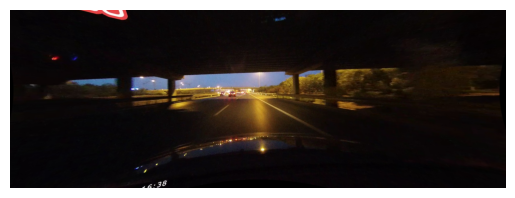

In [2]:
# file_path='C:\\Users\\suvam\\OneDrive - Indian Institute of Science\\DIP Project\\CuLane_Night\\06042013_0512\\'
# image = cv2.imread('3b497cd7-74e42f29.jpg')
# image = cv2.imread("3eb86f80-6bb67f5c.jpg")
# image = cv2.imread("0c34273d-87a7edaa.jpg")
# image = cv2.imread("0d933eed-b74c36f8.jpg")
# image = cv2.imread(file_path+"00300.jpg")
# image = cv2.imread("4cb37643-c72b9003.jpg")
# image = cv2.imread("C:\\Users\\suvam\\OneDrive - Indian Institute of Science\\DIP Project\\CuLane_Night\\DayLight_05151652_0423\\00180.jpg")
# image = cv2.imread("00e9be89-00001005.jpg")

file_path = 'C:\\Users\\suvam\\OneDrive - Indian Institute of Science\\DIP Project\\Chaitanya_Suvam\\CuLane_Night\\06042013_0512\\'
# file_path = 'C:\\Users\\suvam\\OneDrive - Indian Institute of Science\\DIP Project\\CuLane_Night\\DayLight_05151652_0423\\'

image_name = "04950" 
image = cv2.imread(file_path+image_name+".jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height = image.shape[0]
width = image.shape[1]

plt.imshow(image)
plt.axis('off')
plt.show()

# Apply Retinex if Required

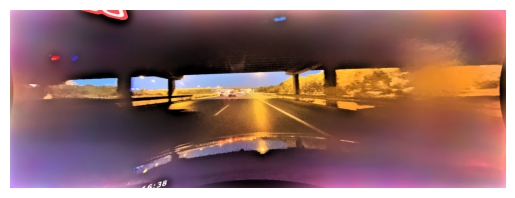

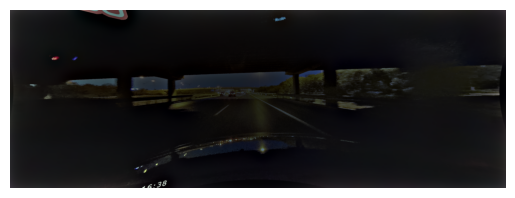

In [3]:
if np.average(image)<70:
    I = image.copy()
    I = np.float32(I)
    I = cv2.bilateralFilter(I, d=100, sigmaColor=20, sigmaSpace=500)
    SSR_1 = Single_SR(I,20)
    SSR_2 = Single_SR(I,80) 
    SSR_3 = Single_SR(I,250)
    MSR = (0.6*SSR_1+0.3*SSR_2+0.1*SSR_3)
    J = Channel_Chromaticity(MSR)
    MSRCR = J*MSR
    J = Normalization(MSRCR)
    H = histogram_equalization(np.uint8(J))
    K = FSCS(J)
    M = MSRCP(I)
    # print(np.uint8(M))
    processed = cv2.bilateralFilter(np.uint8(M), d=20, sigmaColor=10, sigmaSpace=1000)
    gray_image,cannyed_image= canny_out(processed, sigma_g=35, dil_window=2,l_thresh=20,u_thresh=10)
    plt.imshow(np.uint8(processed))
    plt.axis('off')
    plt.show()
    plt.imshow(np.uint8(K))
    plt.axis('off')
    plt.show()

else:
    processed = image.copy()
    gray_image,cannyed_image= canny_out(processed, sigma_g=15, dil_window=2,l_thresh=2,u_thresh=20)
# processed = image.copy()
# gray_image,cannyed_image= canny_out(processed, sigma_g=15, dil_window=2,l_thresh=2,u_thresh=20)

Plot the Processed image

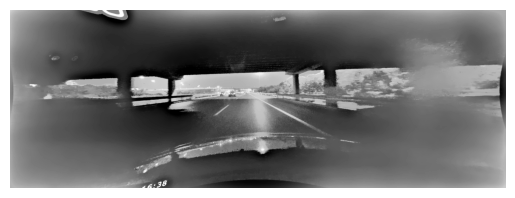

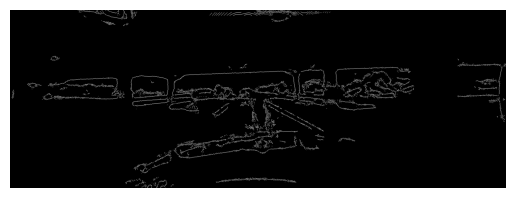

In [4]:

plt.figure()
plt.imshow(gray_image,cmap='gray')
plt.axis('off')
plt.show()
# plt.figure()
# plt.imshow(dilated_image,cmap='gray')
# plt.axis('off')
# plt.show()
plt.figure()
plt.imshow(cannyed_image,cmap='gray')
plt.axis('off')
plt.show()


## If no preprocessing is done, uncomment this

In [5]:
# cannyed_image = cv2.Canny(image, 2,20)
# plt.imshow(cannyed_image)
# plt.axis('off')
# plt.show()

### Define and Apply Region of Interest Cropping

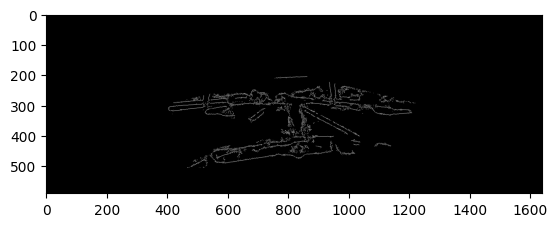

In [6]:
region_of_interest_vertices = [
    (0, height-height//7),  # Bottom-left
    (0, height - height // 3),  # Top-left
    (width / 2, height // 3),  # Top-center
    (width, height - height // 3),  # Top-right
    (width, height-height//7)  # Bottom-right
]
cropped_image = region_of_interest(cannyed_image,np.array([region_of_interest_vertices],np.int32))
plt.imshow(cropped_image,cmap='gray')

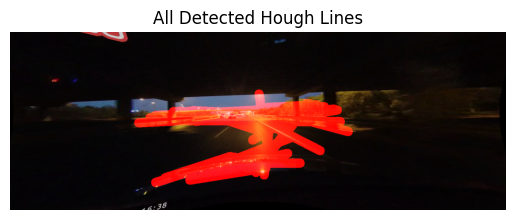

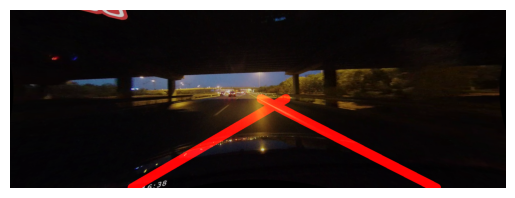

In [11]:

# lines = cv2.HoughLinesP(
#     cropped_image,
#     # cannyed_image,
#     rho=6,
#     theta=np.pi / 60,
#     threshold=160,
#     lines=np.array([]),
#     minLineLength=40,
#     maxLineGap=25
# )
lines = cv2.HoughLinesP(
    cropped_image,
    # cannyed_image,
    rho=6,
    theta=np.pi / 60,
    threshold=40,
    lines=np.array([]),
    minLineLength=180,
    maxLineGap=50)
output_image=image.copy()
all_lines_image  = draw_lines(output_image,lines,thickness=30)
# plt.figure(figsize=(10, 5))
plt.imshow(all_lines_image)
plt.title("All Detected Hough Lines")
plt.axis('off')
plt.show()
line_image, left_x_start,left_x_end, right_x_start, right_x_end,min_y,max_y = get_line_image(output_image,lines=lines,thickness=30)
plt.imshow(line_image,cmap='gray')
plt.axis('off')
plt.show()

In [12]:
# Function to parse lane data from .lines.txt file (using the middle two lanes)
def parse_middle_lanes(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    if len(lines) < 3:
        raise ValueError("Annotation file doesn't contain enough lane data.")

    left_lane, right_lane = [], []

    # Extracting the second left lane (index 1) and the second right lane (index 2)
    left_line = list(map(float, lines[1].split()))  # This picks the second left lane
    right_line = list(map(float, lines[2].split()))  # This picks the second right lane

    left_lane = [(left_line[i], left_line[i+1]) for i in range(0, len(left_line), 2)]  # (x, y) pairs for the second left lane
    right_lane = [(right_line[i], right_line[i+1]) for i in range(0, len(right_line), 2)]  # (x, y) pairs for the second right lane

    return left_lane, right_lane


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


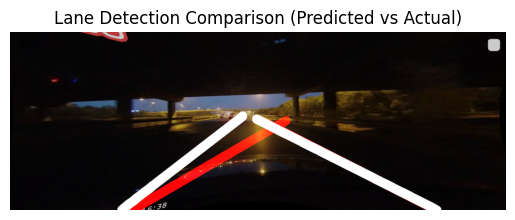

In [13]:
# Read line annotation
annotation_file = file_path+image_name+".lines.txt"
left_lane, right_lane = parse_middle_lanes(annotation_file)

for lane in left_lane:
    # print("Lane (Left):", lane) 
    left_x, left_y = lane 
    # Draw line segments between consecutive points
    for i in range(len(left_lane)-1):  # Loop through left lane points
        pass
        cv2.line(line_image, (int(left_lane[i][0]), int(left_lane[i][1])), (int(left_lane[i+1][0]), int(left_lane[i+1][1])), (255, 255, 255), 30)  # Blue for left lane

for lane in right_lane:
    # print("Lane (Right):", lane) 
    right_x, right_y = lane 
    # Draw line segments between consecutive points
    for i in range(len(right_lane)-1):  # Loop through right lane points
        pass
        cv2.line(line_image, (int(right_lane[i][0]), int(right_lane[i][1])), (int(right_lane[i+1][0]), int(right_lane[i+1][1])), (255, 255, 255), 30)  # Red for right lane

plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Lane Detection Comparison (Predicted vs Actual)')
plt.legend()

plt.imshow(line_image)  
plt.axis('off')  # Hide axis
plt.show()


In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Generate binary masks for predicted and ground truth lanes
predicted_mask = generate_lane_mask(image, left_x_start, left_x_end, right_x_start, right_x_end, max_y, min_y)

# Create the ground truth mask from annotated lanes (left_lane and right_lane)
ground_truth_mask = np.zeros_like(image, dtype=np.uint8)

# Draw the ground truth lanes on the mask
for i in range(len(left_lane) - 1):
    x1, y1 = left_lane[i]
    x2, y2 = left_lane[i+1]
    cv2.line(ground_truth_mask, (int(x1), int(y1)), (int(x2), int(y2)), (255), 30)  

for i in range(len(right_lane) - 1):
    x1, y1 = right_lane[i]
    x2, y2 = right_lane[i+1]
    cv2.line(ground_truth_mask, (int(x1), int(y1)), (int(x2), int(y2)), (255), 30) 

# Calculate F1 score based on pixel overlap between predicted and ground truth masks
f1_score = calculate_pixel_overlap(predicted_mask, ground_truth_mask)

print(f"F1 Score: {f1_score:.4f}")


F1 Score: 0.5438
